In [1]:
from signalalign.hiddenMarkovModel import HmmModel
from signalalign.visualization.plot_em_model_distributions import get_covered_bases
from scipy.stats import norm, invgauss, entropy
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [55]:
model_path = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/sa_training/supervised/more_data_ivt_native/template_hmm9.model"
model = HmmModel(model_path, rna=True)

In [63]:
per_pos_acc = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/sa_training/supervised/more_data_ivt_native/mod_only_local_variant_calling/ivt_native_all/per_position/per_position_data_0.5.csv"
acc_df = pd.read_csv(per_pos_acc)
reference = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/reference/yeast_25S_18S.fa"
positions = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/mod_files/yeast_18S_25S_mods.positions"
mod_percent_path = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/mod_files/misc/mod_file.csv"
mod_df = pd.read_csv(mod_percent_path)



In [64]:
def get_kmer_kl_divergence(model, kmer1, kmer2):
    """Get Kullback–Leibler divergence between the HDP and ONT models for a specific kmer"""
    normal_mean1, normal_sd1 = model.get_event_mean_gaussian_parameters(kmer1)
    normal_mean2, normal_sd2 = model.get_event_mean_gaussian_parameters(kmer2)

    ont_normal_dist1 = norm.pdf(model.linspace, normal_mean1, normal_sd1)
    ont_normal_dist2 = norm.pdf(model.linspace, normal_mean2, normal_sd2)

    kl_divergence = entropy(pk=ont_normal_dist2, qk=ont_normal_dist1, base=2)

    return kl_divergence

def get_kmer_mean_delta(model, kmer1, kmer2):
    """Get Kullback–Leibler divergence between the HDP and ONT models for a specific kmer"""
    normal_mean1, normal_sd1 = model.get_event_mean_gaussian_parameters(kmer1)
    normal_mean2, normal_sd2 = model.get_event_mean_gaussian_parameters(kmer2)

    return np.abs(normal_mean1 - normal_mean2)


In [65]:
get_kmer_kl_divergence(model, "AAAAA", "CAGGA")
get_kmer_mean_delta(model, "AAAAA", "CAGGA")

7.016145999999992

In [66]:
covered_bases = get_covered_bases(reference, positions, kmer_length=5, rna=True)

In [67]:
acc_df.head()
acc_df[(acc_df['contig'] == "RDN18-1") 
       & (acc_df['reference_index'] == 105) 
       & (acc_df["strand"] == "+")]

,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,negative_likelihood_ratio,diagnostic_odds_ratio,f1_score,prevalence,aucroc,avg_precision,brier_score
2,RDN18-1,105,+,Tl,0.8718,0.8557,0.894,0.9171,0.8187,5.0591,0.1977,25.5944,0.8853,0.5396,0.9371,0.9382,0.1012


In [68]:
max_delta_values = []
sum_delta_values = []
aucroc_values = []
av_prec_values = []
brier_scores = []
mod_percents = []
specificity_values = []


for x in covered_bases:
    contig = x[0]
    ref_index = x[1]
    strand = "+"
    kmer_sets = x[3]
    if len(ref_index) == 1:
        ref_index = ref_index[0]
        acc_data = acc_df[(acc_df['contig'] == contig) 
               & (acc_df['reference_index'] == ref_index) 
               & (acc_df["strand"] == strand)]
        if len(acc_data) > 0:
#             print(acc_data[["aucroc", "avg_precision", "brier_score"]])
            kl_divs = []
            mean_deltas = []
            for x in kmer_sets:
                sorted_kmers = sorted(x)
                kl_divs.append(get_kmer_kl_divergence(model, sorted_kmers[0], sorted_kmers[1]))
                mean_deltas.append(get_kmer_mean_delta(model, sorted_kmers[0], sorted_kmers[1]))
#             print(mean_deltas)
            mod_percent = mod_df[(mod_df["contig"] == contig)
                   & (mod_df["pos"] == ref_index+1)]["percent"].iloc[0]
            mod_percents.append(mod_percent)
            aucroc_values.append(acc_data["aucroc"].iloc[0])
            av_prec_values.append(acc_data["avg_precision"].iloc[0])
            brier_scores.append(acc_data["brier_score"].iloc[0])
            specificity_values.append(acc_data["specificity"].iloc[0])

            max_delta_values.append(max(mean_deltas))
            sum_delta_values.append(np.sum(mean_deltas))
            

<IPython.core.display.Javascript object>


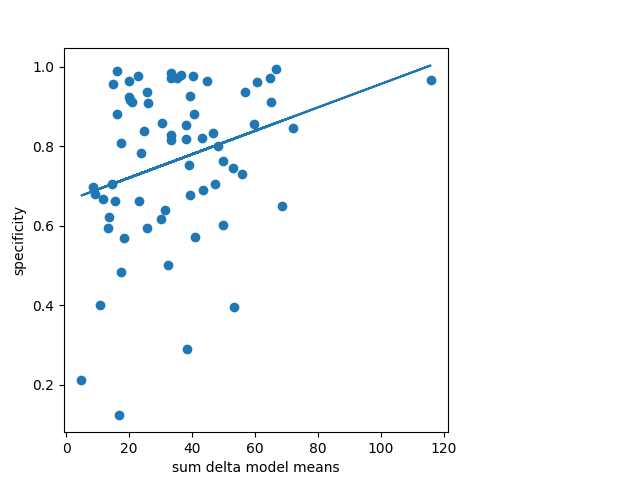

In [87]:
%matplotlib notebook

plt.figure()
panel1 = plt.axes([0.1, 0.1, .6, .8])
panel1.set_xlabel('sum delta model means')
panel1.set_ylabel('specificity')
panel1.scatter(sum_delta_values, specificity_values)
m, b = np.polyfit(sum_delta_values, specificity_values, 1)
panel1.plot(sum_delta_values, m*np.array(sum_delta_values) + b)

plt.show()